# Study for external time precision in Energy resolution 



 # Surface calibration
 For surface calibration, evt files are (usually) previously created with runCompareACDC.sh and calibrated here (test files are those to be calibrated and calibration files are those used for the gainScale curve also).
 - Simulated files (10000p & test files)
 - Reconstructed files
 - Surface creation -> polyfit -> coefficients
 - Calibration of "test" files

In [1]:
# ----IMPORT MODULES --------------
from __future__ import print_function
from __future__ import division
from multiprocessing import Pool, cpu_count
from itertools import repeat
from subprocess import check_call, check_output,STDOUT
from cycler import cycler
from astropy.io import fits
from scipy.stats import norm
from statistics import mean
import math
import sys, os
import shutil, tempfile, shlex
import re
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy.polynomial import Polynomial
import auxpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"


# Define auxiliary functions

In [2]:
def fit_2D_gain_scale(ph_values,phase_values,energy_list,degx=6,degy=6,show=False):
    '''Fits a 2D gain scale giving the energy as a function of ph and phase (by PP)
    
    Arguments:
        - ph_values: 2D array of the measured PH values
        - phase_values: 2D array of the measured phase values
        - energy_list: 1D array of the simulated energies
        - deg: degree of the polynom to fit (in both X and Y)
        - show: option to plot the results
    '''
    ph_values = np.array(ph_values)
    phase_values = np.array(phase_values)
    energies = np.array([energy_list for _ in range(len(ph_values[0]))]).transpose()
    poly_coeffs = polyfit2d(ph_values, phase_values, energies, [degx,degy])
    return poly_coeffs

def polyfit2d(x, y, f, deg):
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = np.polynomial.polynomial.polyvander2d(x, y, deg)
    #print(vander.size)
    #print(vander)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

def find_nearest_idx(array,value):

    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        idx -= 1
    return idx

# Define variables 

In [3]:
#      Simulation options to calculate jitter correction
# ========================================================
dcmt = 100 # decimation factor - NOT USED if BBFB
bbfb = "bbfb" # "" for not_bbfb or "bbfb" for dobbfb in xifusim
smprt = "" # "" or "samprate2" or "samprate4"
Lc = "" # "" for critical damping; otherwise '0.35Lc', '0.5Lc' or '0.7Lc'
npulsesLib = 20000 # number of pulses for libraries
npulsesGain = 10000 # number of pulses for gainScale
preBufferSize = 1000 # old prebuffer (samples before the time of a trigger-pulse to start a record)
Fitting35=3
domain="T"  # or "F"
recStr="OPTFILT" # or "I2R", "I2RNOL", "I2RFITTED", "OPTFILTNM"
pulseLength=8192 # or shorter lengths
ofLength=8192 # for 0-padding or shorter filters otherwise

noiseForSFC = "" # "" for noisy files and "_nonoise" for nonoise files 
if noiseForSFC == "_nonoise": 
    SFCpulses = 1000 # number of pulses for curve/surface creation (nonoise)
    noiseStr="NO NOISE"
if noiseForSFC == "":
    SFCpulses = 10000 # number of pulses for curve/surface creation (noisy)
    noiseStr="NOISY"
    
TSpulses = 2000 # number of pulses for test of FWHM (noisy)
#TSpulses = "2E5" # number of pulses for test of FWHM (noisy)

eurecaDir = "/dataj6/ceballos/INSTRUMEN/EURECA"
sixteDir = eurecaDir + "/testHarness/simulations/SIXTE"
sixteInst = os.environ["SIXTE"] + "/share/sixte/instruments/athena-xifu/"
xmlfile = (sixteInst +
            "/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml")
pairsDir = eurecaDir + "/ERESOL/PAIRS"
impDir = pairsDir + "/PIXIMPACT"
ereDir = pairsDir + "/eresolLPA75um"
gainDir = ereDir + "/gainScale"
tesDir = pairsDir + "/xifusimLPA75um"
coeffsfile = ereDir + "/coeffs_polyfit_externalTime.dat"
surfaceFile = ereDir + "/coeffs_poly2Dfit_externalTime_pL" + str(pulseLength) + "_" + recStr + str(ofLength) + ".dat"
#eners_keV = (0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8)
eners_keV = (1, 2, 3, 4, 5, 6, 7)
#eners_keV = (1,)
libEnergies = (6,) # optimal filter in library
#test_keV = (0.2,0.5,1,2,3,4,5,6,7,8)
test_keV = (1,2,3,4,5,6,7)
#test_keV = (7,)
timeErrors = [0, 0.01e-6, 0.02e-6, 0.05e-6, 0.07e-6, 0.1e-6, 0.15e-6,
              0.2e-6, 0.4e-6, 0.6e-6, 0.8e-6, 1.0e-6, 1.2e-6, 1.4e-6,
              1.6e-6, 1.8e-6, 2.0e-6, 2.2e-6, 2.4e-6, 2.6e-6, 2.8e-6, 3e-6]
timeErrorsStr = ("0","0.01e-6","0.02e-6","0.05e-6","0.07e-6","0.1e-6",
                 "0.15e-6","0.2e-6","0.4e-6","0.6e-6","0.8e-6","1e-6",
                 "1.2e-6","1.4e-6","1.6e-6","1.8e-6","2e-6","2.2e-6",
                 "2.4e-6","2.6e-6","2.8e-6","3e-6")
#timeErrorsStr = ("0")
lagsornot = 0 # Only a reconstruction (not try to find a parabola)
errorT = ("-2","-1","0","1","2")

# samprate
#smprt = "samprate2"
smprt = ""
smprtStr = ""
if smprt == "samprate2":
    #eners_keV = (1, 2, 3, 4, 5, 6, 7,8)
    #test_keV = (1,2,3,4,5,6,7,8)   
    smprtStr = "_samprate2"
    samprate = 78125. # Hz
    nSamples = 4096
    largeFilter = 4096
    pulseLength=4096
    nSgms = 4 #6
    samplesUp = 2 #2
    samplesDown = 4 #3 
    singleSeparation = 20000
    TSexpos=2715 # for the test-noisy pulses
    TSexpos_test = 543 
    #NNexpos=269 # for the nonoise pulses
elif smprt == "samprate4":
    smprtStr = "_samprate4"
    samprate = 39062.5 # Hz
    nSamples = 2048
    largeFilter = 2048
    pulseLength=2048
    nSgms = 4 #6
    samplesUp = 2 #2
    samplesDown = 4 #3 
    singleSeparation = 10000
else:
    samprate = 156250. # Hz
    nSamples = 8192
    largeFilter = 8192
    nSgms = 3.5
    samplesUp = 3
    samplesDown = 4
    singleSeparation = 40000
    TSexpos=2640 # for the test-noisy pulses
    TSexpos_test=525
    #NNexpos=262 # for the nonoise pulses

triggerSizeTC = 1000 + 2*singleSeparation + 1000
triggerSizeTS = preBufferSize + pulseLength + 1000
triggerTS3val = triggerSizeTS - preBufferSize

# jitter
jitterStr = ""
jitterStrPix = ""
offset = 0
#bbfb
bbfbStr = ""
if bbfb == "bbfb":
    bbfbStr = "_bbfb"
    jitterStr = "_jitter"
    jitterStrPix = "_jitter"
elif dcmt > 1 :
    jitterStr = "_jitter_dcmt" + str(dcmt)
    jitterStrPix = "_jitter"
    offset = -1
# Lcrit
LcStr = ""
if not Lc == "":
    LcStr = "_" + Lc + "Lc"

# define optimized colors for offset plots
cols = [(165,0,38),(215,48,39),(244,109,67),(253,174,97),(254,224,144),(224,243,248),(171,217,233),(116,173,209),
        (69,117,180),(49,54,149)]
reversed_cols = cols[::-1]
for i in range(0,len(cols)):
        cols[i] = tuple(round((x/255.),2) for x in reversed_cols[i])
        # print("Color=", cols[i])



# ... and filenames

In [4]:
# a) Filenames for surface fitting and dependency curves 
# ========================================================
impFs = list()
#imp0Fs = list()
evtFs = list()
evtFs_calib = list()
tesFs = list()
libfile = (sixteDir + "/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL" + str(pulseLength) + "_" +
           str(npulsesLib) + "p" + smprtStr + jitterStr + noiseForSFC + bbfbStr + LcStr + ".fits")

for i in range(0,len(eners_keV)):    
    file = (impDir + "/sep" + str(singleSeparation) + "sam_" + str(TSexpos) + "s_" + str(eners_keV[i]) + "keV" +
            smprtStr + jitterStr + "_trSz" + str(triggerSizeTC) + ".piximpact")
    #print(file)
    impFs.append(file)
    
    file = (tesDir + "/sep" + str(singleSeparation) + "sam_" + str(SFCpulses) + "p_" + str(eners_keV[i]) +
            "keV" + smprtStr + jitterStr + noiseForSFC + bbfbStr + LcStr + ".fits")
    #print(file)
    tesFs.append(file)
    
    for j in range(0,len(errorT)):    
        file = (gainDir + "/events_sep" + str(singleSeparation) + "sam_" + str(SFCpulses) + "p_SIRENA" +
                str(nSamples)+ "_pL" + str(pulseLength) + "_" + str(eners_keV[i]) +
                "keV_STC_" + domain+ "_fixedlib6OF_" + recStr + str(ofLength) + smprtStr + jitterStr +
                noiseForSFC + bbfbStr + LcStr + "_NOlags_errorT" + errorT[j] +".fits")
        #print(file)
        evtFs.append(file)
        
        file = (gainDir + "/events_sep" + str(singleSeparation) + "sam_" + str(SFCpulses) + "p_SIRENA" +
                str(nSamples)+ "_pL" + str(pulseLength) + "_" + str(eners_keV[i]) +
                "keV_STC_" + domain+ "_fixedlib6OF_" + recStr + str(ofLength) + smprtStr + jitterStr +
                noiseForSFC + bbfbStr + LcStr + "_NOlags_errorT" + errorT[j] +"_HR.calib")
        evtFs_calib.append(file)

# a) Filenames for test (noisy)
# =============================
test_impFs = list()
test_tesFs = list()
test_evtFs = list()
#test_evtFs_calib = list()
tnpulsesLib = 20000
    
tlibfile = (sixteDir + "/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL" + str(pulseLength) + "_" +
           str(tnpulsesLib) + "p" + smprtStr + jitterStr + bbfbStr + LcStr + ".fits")

for i in range(len(test_keV)):
    file = (impDir + "/sep" + str(singleSeparation) + "sam_" + str(TSexpos_test) + "s_" + str(test_keV[i]) + "keV" +
            smprtStr + jitterStrPix + "_trSz" + str(triggerSizeTC) + ".piximpact")
    #print(file)
    test_impFs.append(file)
    
    file = (tesDir + "/sep" + str(singleSeparation) + "sam_" + str(TSpulses) + "p_" +
            str(test_keV[i]) + "keV" + smprtStr + jitterStr + bbfbStr + LcStr + ".fits")
    #print(file)
    test_tesFs.append(file)
    
    file = (ereDir + "/events_sep" + str(singleSeparation) + "sam_" + str(TSpulses) +
            "p_SIRENA" + str(nSamples)+ "_pL" + str(pulseLength) + "_" + str(test_keV[i]) +
            "keV_STC_" + domain + "_fixedlib6OF_" + recStr + str(pulseLength) + smprtStr + jitterStr +
            bbfbStr + LcStr + "_FT" + str(Fitting35) + "_NOlags" + ".fits")
    test_evtFs.append(file)
    
    #file = (ereDir + "/events_sep" + str(singleSeparation) + "sam_" + str(TSpulses) +
    #        "p_SIRENA" + str(nSamples)+ "_pL" + str(pulseLength) + "_" + str(test_keV[i]) +
    #        "keV_STC_" + domain + "_fixedlib6OF_" + recStr + str(pulseLength) + smprtStr + jitterStr +
    #        bbfbStr + LcStr + "_FT" + str(Fitting35) + "_NOlags" + "_HR.calib")
    #test_evtFs_calib.append(file)


# Data files for surface fitting (NOISY) - those from gainscale

PIXIMPACT -> XIFUSIM (serpens)-> SIRENA(STC) -> CALIBRATED


In [5]:
# RECONSTRUCT surface files
run = 0
# 3) Run SIRENA (AD,STC)
# =======================
if run:
    print("Reconstructing SURFACE (external Time)",SFCpulses, "single files with lib:", libfile)
    print("jitter=",jitterStr,"bbfb=",bbfb,"samprate=",smprtStr, "Lc=", LcStr)
    #sys.exit()
    for i in range(0,len(eners_keV)):
        for j in range(0,len(errorT)):
            comm = ("tesreconstruction Recordfile=" + tesFs[i] + " TesEventFile=" + evtFs[5*i+j] + " Rcmethod=SIRENA" + 
            #comm = ("tesreconstruction Recordfile=" + tesFs[i] + " TesEventFile=" + "bea-2.fits" + " Rcmethod=SIRENA" + 
                    " PulseLength="+ str(pulseLength) + " LibraryFile=" + libfile +
                    " samplesUp=" + str(samplesUp) + " nSgms=" + str(nSgms) + " samplesDown=" + str(samplesDown) + 
                    " opmode=1 OFLib=yes FilterDomain=" + domain + " detectionMode=STC Fitting35=" + str(Fitting35) +
                    " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=" + recStr + 
                    " LagsOrNot=" + str(lagsornot) +
                    " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(pulseLength) +
                    " errorT=" +errorT[j])
            try:
                print("Reconstructing: ", tesFs[i])
                print(comm)
                args = shlex.split(comm)
                check_call(args, stderr=STDOUT)
            except:
                print("Error running tool for SIRENA reconstruction with command:\n", comm)
                shutil.rmtree(tmpDir)
                raise
            #sys.exit()    
    print("########################")        
    print("SIRENA files created")            
    print("########################")        
#sys.exit()

# CALIBRATE Data Filesfor surface fitting

## ONLY to build the error plots

In [6]:
run = 0
if run:
    if smprt == "samprate2":
        print("NOT POSIIBLE: Not included the proper coefficients in the coeffsFile")
    else:
        alias = "pL8192_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb"
    coeffsFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat"
    for i in range(0,len(eners_keV)):
        for j in range(0,len(errorT)):
            auxpy.convertEnergies(evtFs[5*i+j],evtFs_calib[5*i+j],coeffsFile,alias)

# Test Files (noisy): piximpact, xifusim (serpens), uncalE, calE

In [7]:
# RECONSTRUCT test files
run = 0
# 3) Run SIRENA (AD,STC)
# =======================
if run:
    print("Creating SIRENA test files for BBFB=",bbfb,"SAMPRATE=",smprt,"libfile=", tlibfile," and NO lags")
    for i in range(0,len(test_keV)):
        comm = ("tesreconstruction Recordfile=" + test_tesFs[i] + " TesEventFile=" + test_evtFs[i] +
                " Rcmethod=SIRENA" + " PulseLength=" + str(pulseLength) + " LibraryFile=" + tlibfile +
                " samplesUp=" + str(samplesUp) + " nSgms=" + str(nSgms) + " samplesDown=" + str(samplesDown) + 
                " opmode=1 OFLib=yes FilterDomain=" + domain + " detectionMode=STC Fitting35=" + str(Fitting35) +
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=" + recStr + 
                " LagsOrNot=" + str(lagsornot) +
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(pulseLength))
        try:
            print(comm)
            print("Reconstructing: ", test_tesFs[i])
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error running tool for SIRENA reconstruction with command:")
            print(comm)
            raise
    print("########################")        
    print("test SIRENA files created")            
    print("########################")   

#  NOT CORRECT: CALIBRATE Test Files


In [8]:
run = 0
if run:
    alias = "pL8192_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb"
    coeffsFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat"
    for i in range(0,len(test_keV)):
        auxpy.convertEnergies(test_evtFs[i],test_evtFs_calib[i],coeffsFile,alias)

#  Reconstructed Energy vs external Time (NOISY)

## a) Read Surface Data 


In [9]:
# Find number of pulses (after cleaning of xifusim files)
npls = list()
deltat = list()

for i in range(0,len(eners_keV)):
    for j in range(0,len(errorT)):
        #print ("Opening file ",evtFs[5*i+j])
        uncal = fits.open(evtFs[i], memmap=True)
        # To know the minimim number of pulses of the set of different energies
        uncalTab = uncal[1].data
        #print(uncalTab.size)
        npls.append(uncalTab.size)
        uncal.close()
nCpulses = np.amin(npls)
print("nCpulses = ",nCpulses)
#print(len(timeErrorsStr))
print("Plotting curves (external Time) for nCpulses=",nCpulses, "samprate=",samprate, "bbfb=",bbfb, 
      "Lc=",LcStr," and NO lags")

#print("len(eners_keV) = ",len(eners_keV))
#print("len(timeErrorsStr) = ",len(timeErrorsStr))
#time_values = np.zeros((len(eners_keV),nCpulses)) 
#exttime_values = np.zeros((len(eners_keV),nCpulses)) 
#ph_values = np.zeros((len(eners_keV),nCpulses))
#print(exttime_values.shape)

# SIRENA times and Erecons at (5) different offsets (in errorT)
time_values = np.zeros((len(eners_keV),nCpulses*len(errorT))) 
ph_values = np.zeros((len(eners_keV),nCpulses*len(errorT)))
#print("time_values.shape = ",time_values.shape)
exttime_values = np.zeros((len(eners_keV),nCpulses*len(errorT))) 

numlags = 4

for i in range(0,len(eners_keV)):
#for i in range(0,1):
    # Impacts (only to identifyPH)
    #print ("Opening file ",impFile)    
    imp = fits.open(impFs[i], memmap=True)
    impTab = imp[1].data
    impTimes = impTab['TIME']
    imp.close()

    for j in range(0,len(errorT)):
    #for j in range(0,1):
        # Detected events
        #uncal = fits.open(evtFs[i], memmap=True)
        uncal = fits.open(evtFs[5*i+j], memmap=True)
        uncalTab = uncal[1].data
        uncalTimes = uncalTab['TIME']
        uncalEners = uncalTab['SIGNAL']
        for k in range(0,nCpulses):
            time_values[i,j*nCpulses+k] = uncalTimes[k]
            ph_values[i,j*nCpulses+k] = uncalEners[k]
            #if i==7:
            #    if j==0:
            #        if k<10:
            #            print("ph(",k,") =",uncalEners[k])
        #time_values[i,] = uncalTimes[0:nCpulses]
        #ph_values[i,] = uncalEners[0:nCpulses]
        ind = 0
        for k in range(0,len(uncalTimes)):
            clsidx = find_nearest_idx(impTimes, uncalTimes[k])
            #if i == 7:
            #    print(k," ",clsidx," ",impTimes[clsidx]," ",uncalTimes[k]," ",math.fabs(impTimes[clsidx] - uncalTimes[k])," ",(numlags/samprate)," ",ind)
            if (math.fabs(impTimes[clsidx] - uncalTimes[k]) < (numlags/samprate)):
                #print(k," ",clsidx," ",impTimes[clsidx]," ",uncalTimes[k]," ",ind)
                #time_values[i,ind] = uncalTimes[k]
                #ph_values[i,ind] = uncalEners[k]
                #if i==7:
                #    print("ind=",ind," j= ",j," nCpulses=", nCpulses," clsidx=",clsidx)
                exttime_values[i,ind+j*nCpulses] = impTimes[clsidx]
                ind += 1
            #else: 
                #print("No photon",j," ",clsidx," ",impTimes[clsidx]," ",uncalTimes[j]," ",ind)
                #a=1
        uncal.close() 
    #print(time_values[0,75]," ",time_values[0,76]," ",time_values[0,77]," ",time_values[0,78])
    #print(exttime_values[0,75]," ",exttime_values[0,76]," ",exttime_values[0,77]," ",exttime_values[0,78])

    # energy errors
    # look for energy string in name to get simulated energy
 #       srch = re.search('(?<=_)[0.]*[1-9](?=keV_STC)', evtFs[5*i+j])
 #       inkeV = float(srch.group(0))
 #       relErrUncal = (uncalEners - inkeV)*100./inkeV  # [%] Relative uncalEnergy Estimation Error}
        
    # External Time Phase
    diffTime_values = (time_values - exttime_values) #*1e6 #(usec)
    #print("diffTime_values.shape = ",diffTime_values.shape)

# 1 keV
#print("ph_values: ",ph_values[0,0],ph_values[0,1],ph_values[0,2],"...")
#print("time_values: ",time_values[0,0],time_values[0,1],time_values[0,2],"...")
#print("exttime_values: ",exttime_values[0,0],exttime_values[0,1],exttime_values[0,2],"...")
#print("diffTime_values: ",diffTime_values[0,0],diffTime_values[0,1],diffTime_values[0,2],"...")
#print("diffTime_values: ",diffTime_values[0,10013],diffTime_values[0,10014],diffTime_values[0,10015],"...")
#print("diffTime_values: ",diffTime_values[0,50077],diffTime_values[0,50078],diffTime_values[0,50079],"...")
#print("min/max(diffTime_values): ",np.min(diffTime_values[0,]),np.max(diffTime_values[0,]))
#print(np.where(diffTime_values[0,] == np.amax(diffTime_values[0,]))[0])
#print(diffTime_values[6,20031],diffTime_values[6,30047])

nCpulses =  10016
Plotting curves (external Time) for nCpulses= 10016 samprate= 156250.0 bbfb= bbfb Lc=   and NO lags


##  b) Plot 3D surfaces 

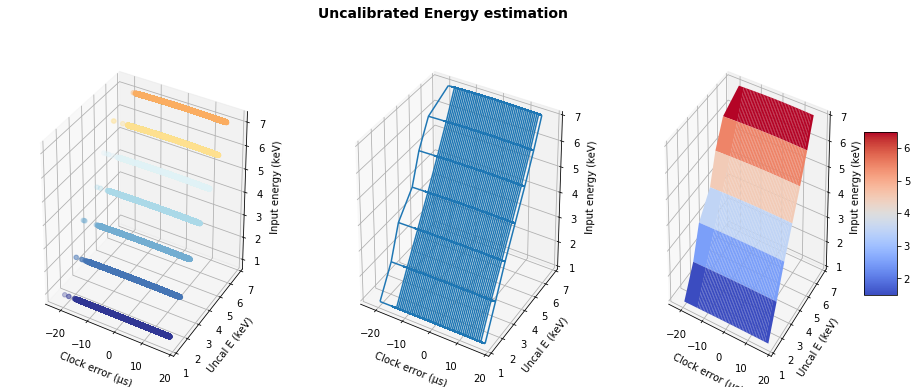

In [10]:
plot=1
if plot:
    
    #npts = len(time_values[1,])
    npts = nCpulses*len(errorT)
    #print("nCpulses=",nCpulses)
    #print("len(errorT)=",len(errorT))
    #print("npts=",npts)
    #print(len(ph_values))
    #print(len(diffTime_values))
    X = np.zeros((len(eners_keV), npts))
    Y = np.zeros((len(eners_keV), npts))
    YS = np.zeros((len(eners_keV), npts))
    Z = np.zeros((len(eners_keV), npts))

    # PLOT      Euncalib  vs. offset  vs. Einput
    # ===============================================
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('Uncalibrated Energy estimation', fontsize=14, fontweight='bold')

    ax = fig.add_subplot(131, projection='3d')
    # At (us) =  timeDetected-timePiximpact
    ax.set_xlabel('Clock error (μs)')
    ax.set_ylabel('Uncal E (keV)')
    ax.set_zlabel('Input energy (keV)')
    for i in range(0,len(eners_keV)):
        X[i,] = diffTime_values[i,]*1e6
        Y[i,] = ph_values[i,]
        Z[i,] = np.repeat(eners_keV[i], npts)
        YS[i,] = [x for _,x in sorted(zip(X[i,],Y[i,]))]
        ax.scatter(xs=X[i,], ys=Y[i,], zs=eners_keV[i], zdir='z', s=20, c=cols[i], depthshade=True)
    XS = np.sort(X,1)

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_wireframe(X=XS, Y=YS, Z=Z)
    ax2.set_xlabel('Clock error (μs)')
    ax2.set_ylabel('Uncal E (keV)')
    ax2.set_zlabel('Input energy (keV)')

    ax3 = fig.add_subplot(133, projection='3d')
    surf = ax3.plot_surface(X=XS, Y=YS, Z=Z, cmap=cm.coolwarm, antialiased=True)
    ax3.set_xlabel('Clock error (μs)')
    ax3.set_ylabel('Uncal E (keV)')
    ax3.set_zlabel('Input energy (keV)')
    fig.colorbar(surf, shrink=0.5, aspect=5)

## c) Plot errors (by using calibrated files)

### NOT PROPERLY calibrated because we are using calibration with LAGS and the energies have been reconstructed without LAGS

In [11]:
plot = 0
if plot:
    # Find number of pulses (after cleaning of xifusim files)
    npls_calib = list()
    deltat_calib = list()

    for i in range(0,len(eners_keV)):
        for j in range(0,len(errorT)):
            #print ("Opening file ",evtFs[5*i+j])
            uncal_calib = fits.open(evtFs_calib[i], memmap=True)
            # To know the minimim number of pulses of the set of different energies
            uncalTab_calib = uncal_calib[1].data
            #print(uncalTab.size)
            npls_calib.append(uncalTab_calib.size)
            uncal_calib.close()
    nCpulses_calib = np.amin(npls_calib)
    print("nCpulses_calib = ",nCpulses_calib)
    #print(len(timeErrorsStr))
    print("Plotting curves (external Time) for nCpulses_calib=",nCpulses_calib, "samprate=",samprate, "bbfb=",bbfb, 
          "Lc=",LcStr," and NO lags")

    time_values_calib = np.zeros((len(eners_keV),nCpulses_calib*len(errorT))) 
    ph_values_calib = np.zeros((len(eners_keV),nCpulses_calib*len(errorT)))
    exttime_values_calib = np.zeros((len(eners_keV),nCpulses_calib*len(errorT))) 

    numlags = 4

    for i in range(0,len(eners_keV)):
    #for i in range(0,1):
        # Impacts (only to identifyPH)
        #print ("Opening file ",impFile)    
        imp_calib = fits.open(impFs[i], memmap=True)
        impTab_calib = imp_calib[1].data
        impTimes_calib = impTab_calib['TIME']
        imp_calib.close()

        for j in range(0,len(errorT)):
        #for j in range(0,1):
            # Detected events
            #uncal = fits.open(evtFs[i], memmap=True)
            uncal_calib = fits.open(evtFs_calib[5*i+j], memmap=True)
            uncalTab_calib = uncal_calib[1].data
            uncalTimes_calib = uncalTab_calib['TIME']
            uncalEners_calib = uncalTab_calib['SIGNAL']
            for k in range(0,nCpulses_calib):
                time_values_calib[i,j*nCpulses_calib+k] = uncalTimes_calib[k]
                ph_values_calib[i,j*nCpulses_calib+k] = uncalEners_calib[k]
                #if i==7:
                #    if j==0:
                #        if k<10:
                #            print("ph(",k,") =",uncalEners[k])
            ind = 0
            for k in range(0,len(uncalTimes_calib)):
                clsidx_calib = find_nearest_idx(impTimes_calib, uncalTimes_calib[k])
                #if i == 7:
                #    print(k," ",clsidx," ",impTimes[clsidx]," ",uncalTimes[k]," ",math.fabs(impTimes[clsidx] - uncalTimes[k])," ",(numlags/samprate)," ",ind)
                if (math.fabs(impTimes_calib[clsidx_calib] - uncalTimes_calib[k]) < (numlags/samprate)):
                    #print(k," ",clsidx," ",impTimes[clsidx]," ",uncalTimes[k]," ",ind)
                    #time_values[i,ind] = uncalTimes[k]
                    #ph_values[i,ind] = uncalEners[k]
                    #if i==7:
                    #    print("ind=",ind," j= ",j," nCpulses=", nCpulses," clsidx=",clsidx)
                    exttime_values_calib[i,ind+j*nCpulses_calib] = impTimes_calib[clsidx_calib]
                    ind += 1
                #else: 
                    #print("No photon",j," ",clsidx," ",impTimes[clsidx]," ",uncalTimes[j]," ",ind)
                    #a=1
            uncal_calib.close() 
        #print(time_values[0,75]," ",time_values[0,76]," ",time_values[0,77]," ",time_values[0,78])
        #print(exttime_values[0,75]," ",exttime_values[0,76]," ",exttime_values[0,77]," ",exttime_values[0,78])

        # energy errors
        # look for energy string in name to get simulated energy
     #       srch = re.search('(?<=_)[0.]*[1-9](?=keV_STC)', evtFs[5*i+j])
     #       inkeV = float(srch.group(0))
     #       relErrUncal = (uncalEners - inkeV)*100./inkeV  # [%] Relative uncalEnergy Estimation Error}
        
        # External Time Phase
        diffTime_values_calib = (time_values_calib - exttime_values_calib) #*1e6 #(usec)
        
    fig1 = plt.figure(figsize=(16,6))
    
    # 1keV
    #=============================================
    ax = fig1.add_subplot(331)
    inkeV = eners_keV[0]
    relErr = (ph_values_calib[0,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    #print(inkeV)
    #print(ph_values_calib[0,0],ph_values_calib[0,1],ph_values_calib[0,2])
    #print(ph_values_calib[0,10016],ph_values_calib[0,10017],ph_values_calib[0,10018])
    #print(ph_values_calib[0,20032],ph_values_calib[0,20033],ph_values_calib[0,20034])
    #print(ph_values_calib[0,30048],ph_values_calib[0,30049],ph_values_calib[0,30050])
    #print(ph_values_calib[0,40064],ph_values_calib[0,40064],ph_values_calib[0,40066])
    labelLeg = "E=" + str(inkeV) + " keV"
    ax.plot(diffTime_values_calib[0,0:10015]*1e6, relErr[0:10015], marker='o', linestyle='none', label=labelLeg, ms=3,color="red")
    ax.plot(diffTime_values_calib[0,10016:20031]*1e6, relErr[10016:20031], marker='o', linestyle='none', label=labelLeg, ms=3,color="orange")
    ax.plot(diffTime_values_calib[0,20032:30047]*1e6, relErr[20032:30047], marker='o', linestyle='none', label=labelLeg, ms=3,color="yellow")
    ax.plot(diffTime_values_calib[0,30048:40063]*1e6, relErr[30048:40063], marker='o', linestyle='none', label=labelLeg, ms=3,color="green")
    ax.plot(diffTime_values_calib[0,40064:50079]*1e6, relErr[40064:50079], marker='o', linestyle='none', label=labelLeg, ms=3,color="blue")
    ax.legend(numpoints=3)
    
    # 2keV
    #=============================================
    ax = fig1.add_subplot(332)
    inkeV = eners_keV[1]
    #print(inkeV)
    #print(ph_values[1,0],ph_values[1,1],ph_values[1,2])
    relErr = (ph_values_calib[1,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    #ax.plot(diffTime_values[1,20032:30047]*1e6, relErr[20032:30047], marker='o', linestyle='none', label=labelLeg, ms=3,color="yellow")
    ax.plot(diffTime_values_calib[1,]*1e6, relErr, marker='o', linestyle='none', label=labelLeg, ms=3)
    ax.legend(numpoints=3)
    
    # 3keV
    #=============================================
    ax = fig1.add_subplot(333)
    inkeV = eners_keV[2]
    #print(inkeV)
    #print(ph_values[2,0],ph_values[2,1],ph_values[2,2])
    relErr = (ph_values_calib[2,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    ax.plot(diffTime_values_calib[2,]*1e6, relErr, marker='o', linestyle='none', label=labelLeg, ms=3)
    #ax.plot(diffTime_values[2,20032:30047]*1e6, relErr[20032:30047], marker='o', linestyle='none', label=labelLeg, ms=3,color="yellow")
    ax.legend(numpoints=3)

    # 4keV
    #=============================================
    ax = fig1.add_subplot(334)
    ax.set_ylabel("Rel. Ener estimation error (%)")
    inkeV = eners_keV[3]
    #print(inkeV)
    #print(ph_values[3,0],ph_values[3,1],ph_values[3,2])
    relErr = (ph_values_calib[3,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    ax.plot(diffTime_values_calib[3,]*1e6, relErr, marker='o', linestyle='none', label=labelLeg, ms=3)
    #ax.plot(diffTime_values[3,20032:30047]*1e6, relErr[20032:30047], marker='o', linestyle='none', label=labelLeg, ms=3,color="yellow")
    ax.legend(numpoints=3)
    
    # 5keV
    #=============================================
    ax = fig1.add_subplot(335)
    inkeV = eners_keV[4]
    #print(inkeV)
    #print(ph_values[4,0],ph_values[4,1],ph_values[4,2])
    relErr = (ph_values_calib[4,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    ax.plot(diffTime_values_calib[4,]*1e6, relErr, marker='o', linestyle='none', label=labelLeg, ms=3)
    #ax.plot(diffTime_values[4,20032:30047]*1e6, relErr[20032:30047], marker='o', linestyle='none', label=labelLeg, ms=3,color="yellow")
    ax.legend(numpoints=3)
    
    # 6keV
    #=============================================
    ax = fig1.add_subplot(336)
    ax.set_xlabel("Clock error (μs)")
    inkeV = eners_keV[5]
    #print(inkeV)
    #print(ph_values[5,0],ph_values[5,1],ph_values[5,2])
    relErr = (ph_values_calib[5,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    ax.plot(diffTime_values_calib[5,]*1e6, relErr, marker='o', linestyle='none', label=labelLeg, ms=3)
    #ax.plot(diffTime_values[5,20032:30047]*1e6, relErr[20032:30047], marker='o', linestyle='none', label=labelLeg, ms=3,color="yellow")
    ax.legend(numpoints=3)
    
    # 7keV
    #=============================================
    ax = fig1.add_subplot(337)
    ax.set_xlabel("Clock error (μs)")
    inkeV = eners_keV[6]
    #print(inkeV)
    #print(ph_values[6,0],ph_values[6,1],ph_values[6,2])
    relErr = (ph_values_calib[6,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    ax.plot(diffTime_values_calib[6,]*1e6, relErr, marker='o', linestyle='none', label=labelLeg, ms=3)
    #ax.plot(diffTime_values[6,20032:30047]*1e6, relErr[20032:30047], marker='o', linestyle='none', label=labelLeg, ms=3,color="yellow")
    ax.legend(numpoints=3)
    
    # 8keV
    #=============================================
    ax = fig1.add_subplot(338)
    ax.set_xlabel("Clock error (μs)")
    inkeV = eners_keV[7]
    print(inkeV)
    #print(ph_values[7,0],ph_values[7,1],ph_values[7,2])
    print(time_values_calib[7,0],time_values_calib[7,1],time_values_calib[7,2],time_values_calib[7,3],time_values_calib[7,4],time_values_calib[7,5])
    print(exttime_values_calib[7,0],exttime_values_calib[7,1],exttime_values_calib[7,2],exttime_values_calib[7,3],exttime_values_calib[7,4],exttime_values_calib[7,5])
    print(diffTime_values_calib[7,0],diffTime_values_calib[7,1],diffTime_values_calib[7,2],diffTime_values_calib[7,3],diffTime_values_calib[7,4],diffTime_values_calib[7,5])
    print(ph_values_calib[7,0],ph_values_calib[7,1],ph_values_calib[7,2],ph_values_calib[7,3],ph_values_calib[7,4],ph_values_calib[7,5])
    relErr = (ph_values_calib[7,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    #ax.plot(diffTime_values[7,]*1e6, relErr, marker='o', linestyle='none', label=labelLeg, ms=3)
    ax.plot(diffTime_values[7,0:10015]*1e6, relErr[0:10015], marker='o', linestyle='none', label=labelLeg, ms=3,color="red")
    #ax.plot(diffTime_values[7,0:10015]*1e6, ph_values[7,0:10015], marker='o', linestyle='none', label=labelLeg, ms=3,color="red")
    #ax.plot(diffTime_values[7,0:999]*1e6, ph_values[7,0:999], marker='o', linestyle='none', label=labelLeg, ms=3,color="red")
    ax.plot(diffTime_values[7,10016:20031]*1e6, relErr[10016:20031], marker='o', linestyle='none', label=labelLeg, ms=3,color="orange")
    ax.plot(diffTime_values_calib[7,20032:30047]*1e6, relErr[20032:30047], marker='o', linestyle='none', label=labelLeg, ms=3,color="yellow")
    ax.plot(diffTime_values[7,30048:40063]*1e6, relErr[30048:40063], marker='o', linestyle='none', label=labelLeg, ms=3,color="green")
    ax.plot(diffTime_values[7,40064:50079]*1e6, relErr[40064:50079], marker='o', linestyle='none', label=labelLeg, ms=3,color="blue")
    #ax.plot(diffTime_values[7,]*1e6, ph_values[7,], marker='o', linestyle='none', label=labelLeg, ms=3)
    #ax.legend(numpoints=3)

# Fitting of a 2D polynomial to Unrecons vs Offsets

Based on PP functions. Functions input:

* Uncorr energies (ph_values): energies are reconstructed with a 20000p library (jitter)

* UnCorrected Arrival time error (diffTime_values)

* Calibration Energies (energy_list)

In [101]:
print("Test of fitting")
#print("ph_values.shape = ",ph_values.shape)
#print("diffTime_values.shape = ",diffTime_values.shape)
#ph_values_vector = []
#diffTime_values_vector = []
#for i in range(0,len(eners_keV)):
#    for j in range(0,nCpulses*len(timeErrorsStr)):
#        ph_values_vector.append(ph_values[i,j])
#        diffTime_values_vector.append(diffTime_values[i,j])
#print("len(ph_values_vector) = ",len(ph_values_vector))
#print("len(diffTime_values_avector) = ",len(diffTime_values_vector))

coeffs=fit_2D_gain_scale(ph_values, diffTime_values, eners_keV, degx=8, degy=6, show=True)
#coeffs=fit_2D_gain_scale(ph_values_vector, diffTime_values_vector, eners_keV, deg=6, show=True)
print(type(coeffs))
print("coeffs.shape = ",coeffs.shape)
print(coeffs)
#print("Einput       ph(i)     PHI_val(i)   ph_corr(calib)(i)  ph_corr(poly)")

# First example
corrE = np.polynomial.polynomial.polyval2d(ph_values[1,1],diffTime_values[1,1],coeffs)
#phcorr not calculated ()
print(eners_keV[1],"    ", ph_values[1,1], diffTime_values[1,1], " ", corrE)

# Second example
corrE = np.polynomial.polynomial.polyval2d(ph_values[2,1],diffTime_values[2,1],coeffs)
print(eners_keV[2],"    ", ph_values[2,1], diffTime_values[2,1], " ", corrE)

# saves coeffs to file
#print(surfaceFile)
np.savetxt(surfaceFile, coeffs, header='Polynomial surface coefficients. Use as: \
    calibEnergy=np.polynomial.polynomial.polyval2d(pulse_height,offset,np.array(coeffs))')


Test of fitting


/home/ceballos/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<class 'numpy.ndarray'>
coeffs.shape =  (9, 7)
[[ 2.53597705e+00  8.72341393e+04  1.67391392e+04  7.08993994e+04
   1.87492211e+05  5.09705328e+05  5.69366220e+04]
 [-2.48036529e+00 -1.90520030e+05  1.25563583e+05  7.43620313e+05
  -6.61976858e+04 -2.13377584e+05  1.70120791e+05]
 [-5.50608547e-01  1.59766919e+05  3.59849246e+05 -1.99991101e+01
  -6.76624374e-05  1.86262249e-09  2.12457963e-08]
 [ 2.83922131e+00 -6.63816978e+04  7.66601526e+05 -8.44056960e+01
  -6.18544112e-04 -1.43331050e-08 -3.24507666e-13]
 [-1.86271315e+00  1.39385351e+04  1.28478448e+06 -3.89153270e+02
  -4.35246666e-03 -5.00538518e-08 -2.09062284e-12]
 [ 5.82168272e-01 -1.08202619e+03  1.20008307e+06 -1.88349282e+03
  -2.84501119e-02 -1.54568648e-07 -1.33182337e-11]
 [-9.79964672e-02 -9.61370606e+01 -8.51727458e+05 -9.35006431e+03
  -1.82940665e-01 -2.45779212e-07 -8.50727027e-11]
 [ 8.55884936e-03  2.29924310e+01  1.62423055e+05 -4.68566350e+04
  -1.18197749e+00  2.07616532e-06 -5.48127523e-10]
 [-3.04697416e-04

# Test files energy corrections

Compare resconstructed energies @ 1keV and 7 keV before and after corrections.
For this, we use *TSpulses* reconstructed with a *jitter_noisy* library using the coefficients calculated below.

In [30]:
print("Correcting energies for ", TSpulses, "pulses with bbfb=", bbfb, "and samprate=",samprate, "Lc=", LcStr,
      " and NO lags")
npls_test = list()
for i in range(0,len(test_keV)):
    #print ("Opening file ",test_evtFs[i])
    uncal = fits.open(test_evtFs[i], memmap=True)
    # To know the minimim number of pulses of the set of different energies
    uncalTab = uncal[1].data
    #print(uncalTab.size)
    npls_test.append(uncalTab.size)
    uncal.close()
nCpulses_test = np.amin(npls_test)
print("nCpulses_test = ",nCpulses_test)

time_values_test = np.zeros((len(test_keV),nCpulses_test*len(timeErrorsStr))) 
ph_values_test = np.zeros((len(test_keV),nCpulses_test*len(timeErrorsStr)))
exttime_values_test = np.zeros((len(test_keV),nCpulses_test*len(timeErrorsStr)))

corrE = np.zeros((len(test_keV),nCpulses_test*len(timeErrorsStr)))

fwhmCorr = np.zeros((len(test_keV),len(timeErrorsStr))) 
fwhmCorr_err = np.zeros((len(test_keV),len(timeErrorsStr))) 
fwhmCorrStr = np.chararray((len(test_keV),len(timeErrorsStr)))
Rss = np.zeros((len(test_keV),len(timeErrorsStr)))
sRss = np.zeros((len(test_keV),len(timeErrorsStr)))

for i in range(0,len(test_keV)):
#for i in range(0,1):
    # Detected uncal events
    #print ("Opening file ",test_evtFs[i])    
    uncal = fits.open(test_evtFs[i], memmap=True)
    uncalTab = uncal[1].data
    uncalTimes = uncalTab['TIME']
    uncalEners = uncalTab['SIGNAL']
    uncal.close()
    for j in range(0,len(timeErrorsStr)):
    #for j in range(0,1):
        # Impacts
        #print ("Opening file0 ",test_impFs[i])  
        if (float(timeErrorsStr[j]) != 0):
            impFile = test_impFs[i] + '.' + timeErrorsStr[j]
        else:
            impFile = test_impFs[i]
        #print ("Opening file1 ",impFile)    
        imp = fits.open(impFile, memmap=True)
        impTab = imp[1].data
        impTimes = impTab['TIME']
        imp.close()
        #print(len(impTimes))
        for k in range(0,nCpulses_test):
            time_values_test[i,j*nCpulses_test+k] = uncalTimes[k]
            ph_values_test[i,j*nCpulses_test+k] = uncalEners[k]
        ind = 0
        for k in range(0,len(uncalTimes)):
            clsidx = find_nearest_idx(impTimes, uncalTimes[k])
            #if i==0:
            #    if j==1:
            #        print(j," ",clsidx," ",impTimes[clsidx]," ",uncalTimes[k]," ",math.fabs(impTimes[clsidx] - uncalTimes[k])," ",(numlags/samprate)," ",ind)
            if (math.fabs(impTimes[clsidx] - uncalTimes[k]) < (numlags/samprate)):
                #print(k," ",clsidx," ",impTimes[clsidx]," ",uncalTimes[k]," ",ind)
                #time_values[i,ind] = uncalTimes[k]
                #ph_values[i,ind] = uncalEners[k]
                exttime_values_test[i,ind+j*nCpulses_test] = impTimes[clsidx]
                ind += 1
        diffTime_values_test = time_values_test - exttime_values_test
        #print("times_values_test0: ",time_values_test[0,0]," ",time_values_test[0,1]," ",time_values_test[0,2])
        #print("exttime_values_test0: ",exttime_values_test[0,0]," ",exttime_values_test[0,1]," ",exttime_values_test[0,2])
        #print("times_values_test1: ",time_values_test[0,1996]," ",time_values_test[0,1997]," ",time_values_test[0,1998])
        #print("exttime_values_test1: ",exttime_values_test[0,1996]," ",exttime_values_test[0,1997]," ",exttime_values_test[0,1998])
        #print("min/max(diffTime_values): ",np.min(diffTime_values_test),np.max(diffTime_values_test))

        corrE[i,j*(nCpulses_test):(j+1)*nCpulses_test] = np.polynomial.polynomial.polyval2d(
            ph_values_test[i,j*nCpulses_test:(j+1)*nCpulses_test], 
            diffTime_values_test[i,j*nCpulses_test:(j+1)*nCpulses_test],
            coeffs
        )
        
        fwhmCorr[i,j] = 2.35*np.std(corrE[i,j*nCpulses_test:(j+1)*nCpulses_test])*1000. # eV
        fwhmCorr_err[i,j] = fwhmCorr[i,j]/np.sqrt(2*float(TSpulses)-2)
        fwhmCorrStr[i,j] = 'FWHM={:0.3f}+/-{:0.3f} eV'.format(fwhmCorr[i,j], fwhmCorr_err[i,j])
        Rss [i,j] =np.sqrt(fwhmCorr[i,j]**2-fwhmCorr[i,0]**2)
        sRss [i,j] = (1/Rss[i,j])*np.sqrt((fwhmCorr[i,j]**2)*(fwhmCorr_err[i,j]**2)+(fwhmCorr[i,0]**2)*(fwhmCorr_err[i,0]**2))
        #sRss [i,j] = (1/np.sqrt(fwhmCorr[i,j]**2-fwhmCorr[i,0]**2))
        #sRss [i,j] = np.sqrt((fwhmCorr[i,j]**2)*(fwhmCorr_err[i,j]**2)+(fwhmCorr[i,0]**2)*(fwhmCorr_err[i,0]**2))
        
    #plt.plot(diffTime_values_test[i,j*nCpulses_test:(j+1)*nCpulses_test]*1e6, corrE[i,j*nCpulses_test:(j+1)*nCpulses_test], marker='o', linestyle='none', ms=3)
    #plt.ylabel("Corrected Energy (keV)")
    #plt.xlabel("Δt (µs)")
    #plt.show()

coordx = (-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2)    
if smprt == "samprate2":
    fwhmCorr_Best = (0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0) # The values in json
    print("En samprate2")
else:
    fwhmCorr_Best = (1.88588,1.95616,2.00665,2.03652,2.11097,2.14849,2.23384,2.38859) # The values in json

timeErrors_usec = list()
for i in range(0,len(timeErrors)):
    timeErrors_usec.append(timeErrors[i]*1e6)
    


Correcting energies for  2000 pulses with bbfb= bbfb and samprate= 156250.0 Lc=   and NO lags
nCpulses_test =  1999


/home/ceballos/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in double_scalars
/home/ceballos/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in sqrt


FWHM, FWHM_ERR= 1.8890895270969734 0.029876598131394063
FWHM0,FWHM0_ERR= 1.8891373539877752 0.02987735453005906
 (Z)Test statistic (standard score)=> 0.001600794212651025 SE

 p-value= 0.5000101000651784 

FWHM, FWHM_ERR= 1.8886579778567227 0.029869773032297414
FWHM0,FWHM0_ERR= 1.8891373539877752 0.02987735453005906
 (Z)Test statistic (standard score)=> 0.016046834403950563 SE

 p-value= 0.5001012460379879 



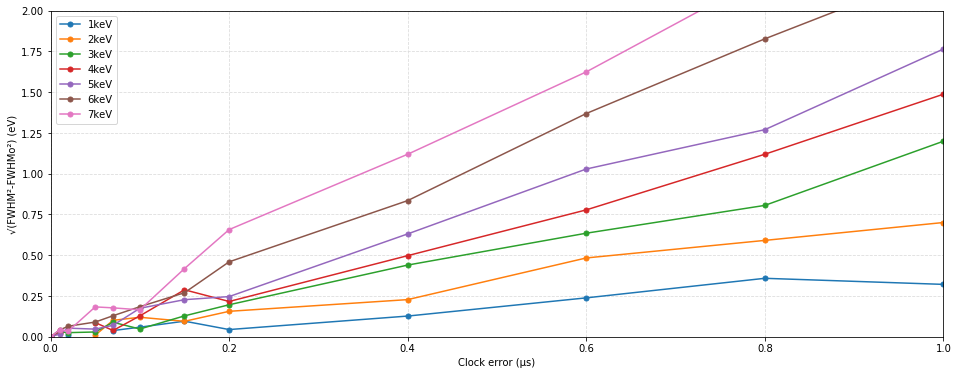

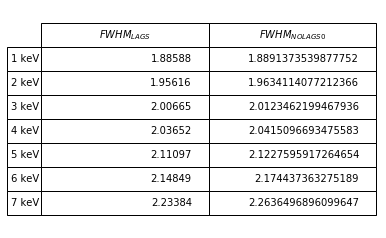

In [31]:
fig = plt.figure(figsize=(16,6))
for i in range(0,len(test_keV)):
    #print(np.max(fwhmCorr[i,]))
    #plt.plot([k*1e6 for k in timeErrors],fwhmCorr[i,], marker='o', linestyle='none', ms=3)
    plt.rc('grid', linestyle="--", color='gainsboro')
    #plt.plot(timeErrors_usec,(fwhmCorr[i,]**2-fwhmCorr_Best[i]**2)**0.5, marker='o', linestyle='solid', ms=5,label=str(test_keV[i])+'keV')
    #plt.plot(timeErrors_usec,(fwhmCorr[i,]**2-fwhmCorr[i,0]**2)**0.5, marker='o', linestyle='solid', ms=5,label=str(test_keV[i])+'keV')
    #plt.errorbar([k for k in timeErrors_usec],Rss[i,],yerr=sRss[i,], marker='o', linestyle='solid', ms=5,label=str(test_keV[i])+'keV')
    plt.plot(timeErrors_usec,Rss[i,], marker='o', linestyle='solid', ms=5,label=str(test_keV[i])+'keV')
    #if i ==0:
        #plt.errorbar([k for k in timeErrors_usec],Rss[i,],yerr=sRss[i,], marker='o', linestyle='solid', ms=5,label=str(test_keV[i])+'keV')
        #print("Rss: ",Rss[i,])
        #print("F1: ",fwhmCorr[i,2])
        #print("sF1: ",fwhmCorr_err[i,2])
        #print("F2: ",fwhmCorr[i,0])
        #print("sF2: ",fwhmCorr_err[i,0])
    
    # for 1keV print FWHM and significance of negative difference
    if i == 0: 
        for j in range(0,len(fwhmCorr[i,])):
            if (fwhmCorr[i,j] - fwhmCorr[i,0]) < 0:
                f1 = fwhmCorr[i,j]
                f1_err = fwhmCorr_err[i,j]
                f0 = fwhmCorr[i,0]
                f0_err = fwhmCorr_err[i,0]
                print("FWHM, FWHM_ERR=",f1, f1_err)
                print("FWHM0,FWHM0_ERR=",f0, f0_err)
                stat_f1_f0 = abs(f1-f0)/mean([f1_err,f0_err])
                print(" (Z)Test statistic (standard score)=>",stat_f1_f0,"SE\n")
                val1 = max(f1,f0)
                val2 = min(f1,f0)
                mn = mean([f1,f0])
                #pvalue<-sprintf("%.4f",pnorm(val1,val2,mn,lower.tail = FALSE))
                pvalue = norm.cdf(val1,val2,mn)
                print(" p-value=",pvalue,"\n")

        
        
    plt.ylabel("\u221A(FWHM²-FWHMo²) (eV)")
    #plt.errorbar([k*1e6 for k in timeErrors],fwhmCorr[i,],yerr=fwhmCorr_err[i,], marker='o', linestyle='none', ms=2,label=str(test_keV[i])+'keV')
    #plt.ylabel("Energy Resolution FWHM (eV)")
    plt.xlabel("Clock error (µs)")
    plt.legend()
    #plt.yscale('log')
    plt.xlim(0,1)
    plt.ylim(0,2)
    
    
#for i in range(0,len(test_keV)):
#    plt.rc('grid', linestyle="--", color='gainsboro')
#    plt.plot([-0.2], [fwhmCorr_Best[i]], 'bo',ms=2)

plt.grid(True)
plt.show()
#fileplot = ("FWHMvsClockerror_ikeV.png")
############fig.savefig('FWHMvsClockerror_ikeV.png', dpi=fig.dpi)

    
#plt.figure()
#ax=plt.gca()
#y=[1,2,3,4,5,4,3,2,1,1,1,1,1,1,1,1]
#plt.plot([10,10,14,14,10],[2,4,4,2,2],'r')
params = {'mathtext.default': 'regular' }
col_labels=["$FWHM_{LAGS}$","$FWHM_{NOLAGS0}$"]
#row_labels=['1 keV','2 keV','3 keV','4 keV','5 keV','6 keV','7 keV','8 keV']
row_labels=['1 keV','2 keV','3 keV','4 keV','5 keV','6 keV','7 keV']
#table_vals=[[fwhmCorr_Best[0],fwhmCorr[0,0]],[fwhmCorr_Best[1],fwhmCorr[1,0]],
#            [fwhmCorr_Best[2],fwhmCorr[2,0]],[fwhmCorr_Best[3],fwhmCorr[3,0]],
#            [fwhmCorr_Best[4],fwhmCorr[4,0]],[fwhmCorr_Best[5],fwhmCorr[5,0]],
#            [fwhmCorr_Best[6],fwhmCorr[6,0]],[fwhmCorr_Best[7],fwhmCorr[7,0]]]
table_vals=[[fwhmCorr_Best[0],fwhmCorr[0,0]],[fwhmCorr_Best[1],fwhmCorr[1,0]],
            [fwhmCorr_Best[2],fwhmCorr[2,0]],[fwhmCorr_Best[3],fwhmCorr[3,0]],
            [fwhmCorr_Best[4],fwhmCorr[4,0]],[fwhmCorr_Best[5],fwhmCorr[5,0]],
            [fwhmCorr_Best[6],fwhmCorr[6,0]]]
#
#the rectangle is where I want to place the table
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.25]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(2, 2)
#plt.text(12,3.4,'',size=8)
#plt.plot(y)
#plt.show()

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
    




(-0.4, 0.4)

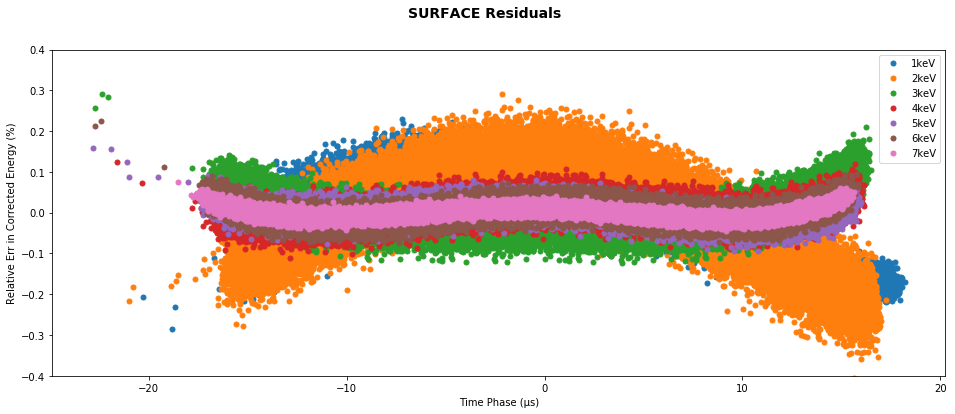

In [102]:
# RESIDUALS for SURFACE (2D plot)
# ================================
fig = plt.figure(figsize=(16,6))
fig.suptitle('SURFACE Residuals', fontsize=14, fontweight='bold')
for i in range(0,len(eners_keV)):
    inkeV = eners_keV[i]
    correctedE[i,] = np.polynomial.polynomial.polyval2d(ph_values[i,],diffTime_values[i,],coeffs)
    plt.plot(1e6*diffTime_values[i,], (correctedE[i,]- inkeV)/inkeV*100,
             marker='o', linestyle='', ms=5,label=str(test_keV[i])+'keV')
    plt.legend()
plt.xlabel('Time Phase (μs)')
plt.ylabel('Relative Err in Corrected Energy (%)')
plt.ylim(-0.4,0.4)

CorrE(7keV,1500)= 7.001329735538232


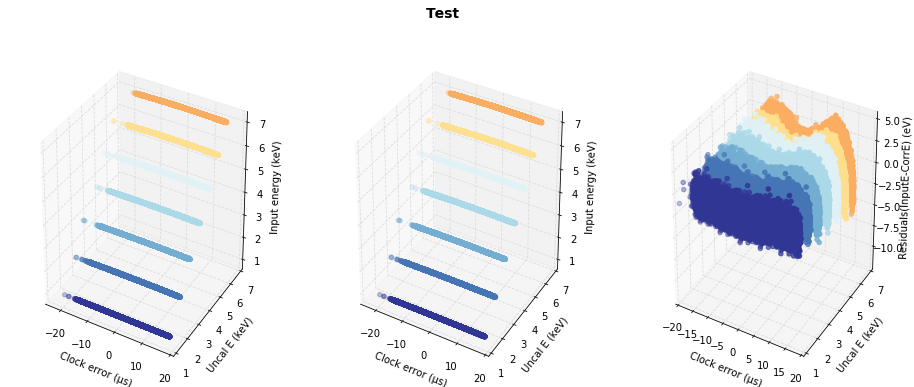

In [77]:
# PLOT INITIAL DATA & RESIDUALS
# 1) DATA for SURFACE
# -------------------
fig = plt.figure(figsize=(16,6))
fig.suptitle('Test', fontsize=14, fontweight='bold')
ax = fig.add_subplot(131, projection='3d')
# At (us) =  timeDetected-timePiximpact
ax.set_xlabel('Clock error (μs)')
ax.set_ylabel('Uncal E (keV)')
ax.set_zlabel('Input energy (keV)')
for i in range(0,len(eners_keV)):
    X[i,] = diffTime_values[i,]*1e6
    Y[i,] = ph_values[i,]
    ax.scatter(xs=X[i,], ys=Y[i,], zs=eners_keV[i], zdir='z', s=20, c=cols[i], depthshade=True)
    
# 2) RECONSTRUCTED energies for surface input data 
# ------------------------------------------------
ax2 = fig.add_subplot(132, projection='3d')
# At (us) =  timeDetected-timePiximpact
ax2.set_xlabel('Clock error (μs)')
ax2.set_ylabel('Uncal E (keV)')
ax2.set_zlabel('Input energy (keV)')
correctedE = np.zeros((len(test_keV),npts))
for i in range(0,len(eners_keV)):
    X[i,] = diffTime_values[i,]
    Y[i,] = ph_values[i,]
    correctedE[i,] = np.polynomial.polynomial.polyval2d(ph_values[i,],diffTime_values[i,],coeffs)
    ax2.scatter(xs=X[i,]*1e6, ys=Y[i,], zs=correctedE[i,], zdir='z', s=20, c=cols[i], depthshade=True)
    
# 3) RESIDUALS in input data (RECONSTRUCTED - input_simulated)
# --------------------------------------------------------------
ax3 = fig.add_subplot(133, projection='3d')
# At (us) =  timeDetected-timePiximpact
ax3.set_xlabel('Clock error (μs)')
ax3.set_ylabel('Uncal E (keV)')
ax3.set_zlabel('Residuals(InputE-CorrE) (eV)')
ax3.set_xlim([-20,20])
for i in range(0,len(eners_keV)):
    X[i,] = diffTime_values[i,]
    Y[i,] = ph_values[i,]
    ax3.scatter(xs=X[i,]*1e6, ys=Y[i,], zs=(eners_keV[i]-correctedE[i,])*1e3, zdir='z', s=20, 
                c=cols[i], depthshade=True)
print("CorrE(7keV,1500)=", correctedE[6,1500])

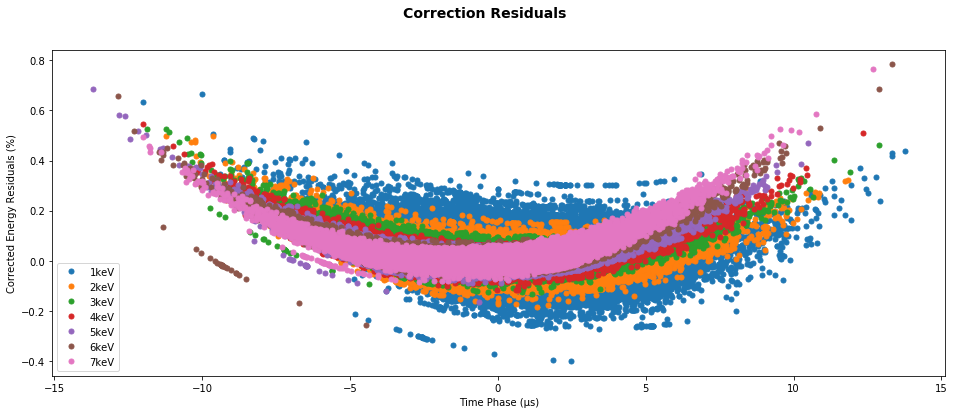

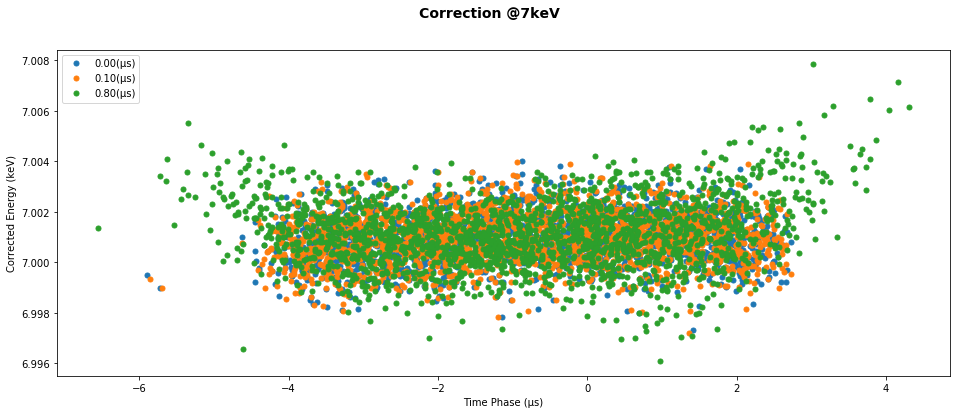

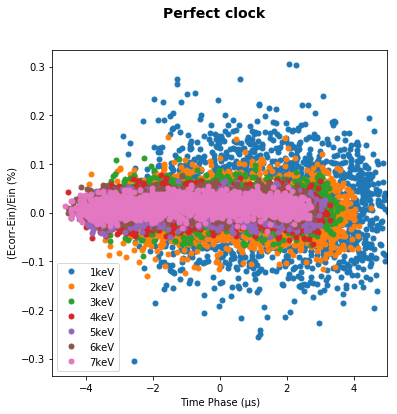

FWHM0[6keV]]= 2.174437363275189


In [61]:
# PLOT CORRECTION RESIDUALS
fig = plt.figure(figsize=(16,6))
fig.suptitle('Correction Residuals', fontsize=14, fontweight='bold')
# At (us) =  timeDetected-timePiximpact
plt.xlabel('Time Phase (μs)')
plt.ylabel('Corrected Energy Residuals (%)')

for i in range(0,len(eners_keV)):
    inkeV = eners_keV[i]
    plt.plot(1e6*diffTime_values_test[i,], (corrE[i,]- inkeV)/inkeV*100,
             marker='o', linestyle='', ms=5,label=str(test_keV[i])+'keV')
    plt.legend()
plt.show()

#plot corrected energy@7keV
fig = plt.figure(figsize=(16,6))
fig.suptitle('Correction @7keV', fontsize=14, fontweight='bold')
plt.xlabel('Time Phase (μs)')
plt.ylabel('Corrected Energy (keV)')

inkeV = eners_keV[6]
#for j in range(0,len(timeErrors)):
for j in [0,5,10]:
    plt.plot(1e6*diffTime_values_test[6,j*nCpulses_test:(j+1)*nCpulses_test], 
             corrE[6,j*nCpulses_test:(j+1)*nCpulses_test],
             marker='o', linestyle='', ms=5,label=('{:.2f}'.format(timeErrors_usec[j])+"(μs)"))
plt.legend()
plt.show()

# plot only corrected photons for clock=0
fig = plt.figure(figsize=(6,6))
fig.suptitle('Perfect clock', fontsize=14, fontweight='bold')
for i in range(0,len(eners_keV)):
    inkeV = eners_keV[i]
    plt.plot(1e6*diffTime_values_test[i,0:nCpulses_test], (corrE[i,0:nCpulses_test]- inkeV)/inkeV*100,
        marker='o', linestyle='', ms=5,label=str(test_keV[i])+'keV')
fwhmCorr[5,0] = 2.35*np.std(corrE[5,0:nCpulses_test])*1000. # eV
plt.xlabel('Time Phase (μs)')
plt.ylabel('(Ecorr-Ein)/Ein (%)')
plt.legend()
plt.xlim(-5,5)
plt.show()
print("FWHM0[6keV]]=",fwhmCorr[5,0])

In [39]:
print(nCpulses_test)
print(len(errorT))
#time_values = np.zeros((len(eners_keV),nCpulses*len(errorT))) 

print(len(diffTime_values_test[1,]))
print(len(timeErrorsStr))

1999
5
43978
22
